This document is referring to the third course project of the COS "Applied Data Science: Machine Learning"
# Course Project Topic: Part 2 - House prices
House prices data set assembled and published by Dean De Cock (2,930 observations with 82 attributes each)

The goal is to use the first 2,430 ones to fit and evaluate different models and use them to make predictions for the last 500 ones

The prices for those 500 houses are not provided, your task is to estimate them




> - Detailed data description - documentation.txt (http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
> - The 2,430 data points with prices - house-prices.csv
> - The remaining 500 without prices - house-prices-test.csv
> - Example submission file - predictions-example.csv
> - Data set source - source.txt

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('house-prices.csv')
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


There are 82 columns in the data sets. 39 of them are numerical columns.

In [3]:
df.shape

(2430, 82)

## Data cleaning

Your analysis should include the necessary data cleaning steps. For instance

- Find and handle incorrect, missing values
- Correct inconsistencies in the variables
- Handle outliers

You are free to choose your preferred approach to handle each step. For instance, you might want to replace missing values with the average or the most frequent value or create a missing category. In any case, justify your choices!

You should **address all these issues** during the data cleaning stage:

- The Order and PID variables are identifiers. They are not useful to predict house prices.
- The variables are not necessarily encoded consistently. For instance, MS SubClass (the type of dwelling) and MS Zoning (zoning classification) are both categorical variables, but one is encoded with numerical values and the other with short labels.
- The data isn't clean: there are incorrect and missing values, outliers and inconsistencies

-------

1. Find and handle incorrect, missing values

In [4]:
# ensure a consistenc encoding of the dtype
df[['Order', 'PID', 'MS SubClass']] = df[['Order', 'PID', 'MS SubClass']].astype('object')

In [5]:
df['Order'].duplicated().value_counts()

False    2430
Name: Order, dtype: int64

In [6]:
df['PID'].duplicated().value_counts()

False    2430
Name: PID, dtype: int64

Let's have a look at the null values at a first glance:

In [7]:
df[df.columns[df.isna().any()].tolist()].isnull().sum().sort_values(ascending=False)

Pool QC           2418
Misc Feature      2340
Alley             2267
Fence             1941
Fireplace Qu      1186
Lot Frontage       420
Garage Yr Blt      138
Garage Cond        138
Garage Qual        138
Garage Finish      138
Garage Type        136
Bsmt Exposure       74
BsmtFin Type 2      72
Bsmt Cond           71
Bsmt Qual           71
BsmtFin Type 1      71
Mas Vnr Type        20
Mas Vnr Area        20
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Area          1
Electrical           1
dtype: int64

An NaN value can encode the absence of value or the absence of information:

For instance Pool QC has a relatively high proportion of null values (compared to a total data points of 2430). This is because the variable belongs to a **categorial** one that includes a 'No Pool' category (reflected as N/A in the data set, meaning no category available as opposed to missing data). Therefore the high proprotion is not based on bad data quality. The following categorial variables include a category related to (N/A) according to the documentation:

**Ordinal variables** (you can order the categories): 
> *Alley, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin Type 2, Fireplace Qu, Garage Type, Garage Finish, Garage Qual, Garage Cond, Pool QC, Fence, Misc Feature*

We can drop the columns if they include a high proportion of N/A values (threshold: 10% of total data points, approx. 2200 null values) because it makes our model more complex without adding much value in terms of information (i.e. the feature does not carry significant information about the target). However at this stage it is not advised to remove it (having a little information is better than removing it which erases this information). Removing variables will decrease the accuracy of our predictions since the model is less informed about the house for which it has to estimate the price. The solution in such case is simply to **use a model with regularization** (will be applied later in the analysis).

In [8]:
df_ordinals = df.loc[:,['Alley', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature']]

In [9]:
df_ordinals[df_ordinals.columns[df_ordinals.isna().any()].tolist()].isnull().sum().sort_values(ascending=False)

Pool QC           2418
Misc Feature      2340
Alley             2267
Fence             1941
Fireplace Qu      1186
Garage Cond        138
Garage Qual        138
Garage Finish      138
Garage Type        136
Bsmt Exposure       74
BsmtFin Type 2      72
BsmtFin Type 1      71
Bsmt Cond           71
Bsmt Qual           71
dtype: int64

Let's proceed to the **numerical** variables where null values are indicating real bad data. These columns/data points need a closer look and possibly handling of null values. 

The following discrete variables contain categories (e.g. 0/1 or 0/1/2/3/4/5/6) according to the documentation/data set and therefore contain information in the related 0 data points: 

**Discrete variables** (categories are integer values): 
>*Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, TotRms AbvGrd, Fireplaces, Garage Cars, Mo Sold* 

-> all other numerical variables (= continous variables) with 0 or 0.0 can be replaced with null values:


In [10]:
df_discrete = df.loc[:,['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Mo Sold', 'Overall Qual', 'Overall Cond']]

In [11]:
df_num = df.select_dtypes(['float64', 'int64']).astype('float64')

In [12]:
df_num = df_num.drop(df_discrete.columns, axis=1)

In [13]:
df.loc[:,df_num.columns] = df.loc[:,df_num.columns].replace([0,0.0], np.nan, inplace=False)

In [14]:
df[df.columns[df.isna().any()].tolist()].isnull().sum().sort_values(ascending=False)

Pool QC            2418
Pool Area          2418
3Ssn Porch         2401
Low Qual Fin SF    2400
Misc Val           2342
Misc Feature       2340
Alley              2267
Screen Porch       2212
BsmtFin SF 2       2136
Enclosed Porch     2055
Fence              1941
Mas Vnr Area       1458
2nd Flr SF         1405
Wood Deck SF       1272
Fireplace Qu       1186
Open Porch SF      1080
BsmtFin SF 1        774
Lot Frontage        420
Bsmt Unf SF         211
Garage Yr Blt       138
Garage Finish       138
Garage Cond         138
Garage Qual         138
Garage Area         137
Garage Type         136
Bsmt Exposure        74
BsmtFin Type 2       72
BsmtFin Type 1       71
Bsmt Cond            71
Bsmt Qual            71
Total Bsmt SF        71
Mas Vnr Type         20
Bsmt Full Bath        2
Bsmt Half Bath        2
Garage Cars           1
Electrical            1
dtype: int64

Let's take a closer look on the **continous** (numerical) variables in order to take appropriate actions with regards to null values. Most of them do not require special treatment of null values because they are reflecting an "absence" of the respective variable. For instance a lot of houses have no 'Pool Area' data points because they simply do not have a pool as reflected in the same amount of null values of 'Pool QC'. There is no need to replace missing values with a newly created missing category (null is already reflecting the absence). After comparison of the documentation with the isnull() list above the following variables have to be analyzed:

> - Lot Frontage: there has to be some street connected to the house - replace the missing values of Lot Frontage with the mean value of the column. Assumption: there is a correlation with the MS Zoning (e.g. the linear feet of street connected to an industrial zone is probably higher on average than connected to a residential high density zone)
> - Garage variables: for instance Yr Blt could be replaced with the Year Built of the house in the respective data point because there is a high correlation (see below) but apparently the data set is not missing values because all the related garage variables have null values
> - Basement variables: same logic applied as with Garage and therefore no handling of the null values - validating that the data reveals consistency ex. a house without a garage should have consistent Garage {Qual, Yr Blt, Cars, ..} values.
> - The remaining variables with null values can be neglected due to very low amount of data points being null


In [15]:
# Lot Frontage
df['Lot Frontage']=df.groupby(['Lot Config','MS Zoning'])['Lot Frontage'].transform(lambda x: x.fillna(x.median()))

In [16]:
# Garage variables
df.corr().loc['Garage Yr Blt', 'Year Built']

0.8355102326795137

In [17]:
# validate that the data is consistent ex. a house without a garage should have consistent Garage {Qual, Yr Blt, Cars, ..}
df[df['Garage Cars'] == 0].loc[:,['Garage' in str(x) for x in df.columns]].isnull().sum()

Garage Type      136
Garage Yr Blt    136
Garage Finish    136
Garage Cars        0
Garage Area      136
Garage Qual      136
Garage Cond      136
dtype: int64

In [18]:
# Basement variables
df[df['Bsmt Exposure'].isna()].loc[:,['Bsmt' in str(x) for x in df.columns]]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


2. Correct inconsistencies in the variables

"In general, a simple way to detect both cases is with the Pandas value_counts() function which counts the number of occurences for each categorical value and sorts the results by frequency. Statistically, such incorrect categorical values will only happen once (or a very few times at best) and will appear at the beginning of the sorted list":

In [19]:
#df['construction year'].value_counts().sort_values()
# 20020: 1 occurrence <-- strange!
# 2018: 51 occurrences
# 2020: 83 occurrences
# 2019: 130 occurrences
# ..

Check object columns, ordinal and discrete variables for inconsistencies:

In [20]:
# no inconsistencies found for object related columns
columns = df.select_dtypes('object').columns
for column in columns:
    print(df[column].value_counts().sort_values())

2930    1
2908    1
2928    1
2927    1
2926    1
       ..
5       1
4       1
3       1
21      1
1       1
Name: Order, Length: 2430, dtype: int64
527450110    1
909275110    1
905478140    1
535126010    1
528228345    1
            ..
534278150    1
909452050    1
534450180    1
535425060    1
902111010    1
Name: PID, Length: 2430, dtype: int64
150      1
40       4
180     14
45      15
75      19
85      41
190     55
90      86
80      94
160    103
70     107
30     119
120    159
50     231
60     470
20     912
Name: MS SubClass, dtype: int64
I (all)       2
A (agr)       2
C (all)      17
RH           19
FV          113
RM          383
RL         1894
Name: MS Zoning, dtype: int64
Grvl      11
Pave    2419
Name: Street, dtype: int64
Pave     59
Grvl    104
Name: Alley, dtype: int64
IR3      14
IR2      66
IR1     836
Reg    1514
Name: Lot Shape, dtype: int64
Low      54
HLS      98
Bnk     102
Lvl    2176
Name: Land Contour, dtype: int64
NoSeWa       1
NoSewr       2
AllPu

In [21]:
# no inconsistencies found for ordinal variables
columns = df_ordinals.columns
for column in columns:
    print(df[column].value_counts().sort_values())

Pave     59
Grvl    104
Name: Alley, dtype: int64
Po       1
Fa      75
Ex     213
Gd    1008
TA    1062
Name: Bsmt Qual, dtype: int64
Ex       2
Po       4
Fa      82
Gd     101
TA    2170
Name: Bsmt Cond, dtype: int64
Mn     208
Gd     235
Av     350
No    1563
Name: Bsmt Exposure, dtype: int64
LwQ    124
BLQ    227
Rec    242
ALQ    352
Unf    703
GLQ    711
Name: BsmtFin Type 1, dtype: int64
GLQ      28
ALQ      45
BLQ      61
LwQ      75
Rec      84
Unf    2065
Name: BsmtFin Type 2, dtype: int64
Ex     38
Po     42
Fa     67
TA    477
Gd    620
Name: Fireplace Qu, dtype: int64
CarPort      11
2Types       22
Basment      28
BuiltIn     147
Detchd      650
Attchd     1436
Name: Garage Type, dtype: int64
Fin     596
RFn     665
Unf    1031
Name: Garage Finish, dtype: int64
Ex       2
Po       5
Gd      20
Fa     109
TA    2156
Name: Garage Qual, dtype: int64
Ex       2
Gd      13
Po      14
Fa      61
TA    2202
Name: Garage Cond, dtype: int64
Fa    2
Gd    3
TA    3
Ex    4
Name: P

In [22]:
# no inconsistencies found for discrete variables
columns = df_discrete.columns
for column in columns:
    print(df[column].value_counts().sort_values())

3.0       2
2.0      34
1.0     980
0.0    1412
Name: Bsmt Full Bath, dtype: int64
2.0       3
1.0     140
0.0    2285
Name: Bsmt Half Bath, dtype: int64
4       3
0      11
3      46
1    1097
2    1273
Name: Full Bath, dtype: int64
2      22
1     854
0    1554
Name: Half Bath, dtype: int64
8       1
0       8
6      12
5      40
1      93
4     327
2     620
3    1329
Name: Bedroom AbvGr, dtype: int64
3       1
0       2
2     104
1    2323
Name: Kitchen AbvGr, dtype: int64
15      1
13      1
14      1
2       1
12     11
11     22
3      22
10     60
9     122
4     170
8     281
5     501
7     537
6     700
Name: TotRms AbvGrd, dtype: int64
4       1
3      10
2     179
1    1054
0    1186
Name: Fireplaces, dtype: int64
4.0      12
0.0     136
3.0     306
1.0     635
2.0    1340
Name: Garage Cars, dtype: int64
12     92
1     108
2     109
11    112
9     135
10    143
8     186
3     187
4     227
5     335
7     374
6     422
Name: Mo Sold, dtype: int64
1       4
2      12
10 

In [23]:
columns = df_num.columns
for column in columns:
    print(df[column].value_counts().sort_values())

141.0      1
123.0      1
113.0      1
150.0      1
182.0      1
        ... 
80.0     112
85.0     146
50.0     178
60.0     237
70.0     301
Name: Lot Frontage, Length: 122, dtype: int64
4750      1
18261     1
3950      1
3940      1
10083     1
         ..
10800    20
9000     26
6000     28
7200     34
9600     35
Name: Lot Area, Length: 1695, dtype: int64
1875      1
1907      1
1911      1
1879      1
1893      1
       ... 
2003     75
2004     84
2007     87
2006    109
2005    116
Name: Year Built, Length: 115, dtype: int64
1982      8
1983      9
1987      9
1981     10
2010     11
       ... 
2004     95
2005    115
2007    133
2006    162
1950    294
Name: Year Remod/Add, Length: 61, dtype: int64
258.0     1
564.0     1
452.0     1
760.0     1
468.0     1
         ..
216.0     9
176.0    10
144.0    11
200.0    12
120.0    14
Name: Mas Vnr Area, Length: 407, dtype: int64
615.0      1
1505.0     1
1127.0     1
1733.0     1
475.0      1
          ..
600.0      7
288.0      7

**Findings:**
- Garage Yr Blt: year '2207' is not possible

In [24]:
df[df['Garage Yr Blt'] >2010].loc[:,['Garage Yr Blt']].index[0]

2219

In [25]:
df.loc[df[df['Garage Yr Blt'] >2010].loc[:,['Garage Yr Blt']].index[0],'Garage Yr Blt'] = np.nan

Identify rows with negative values for numeric variables:

In [26]:
for cols in df_num.columns.tolist()[1:]:
    data = df_num.index[df_num[cols] < 0]
    print(data)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [27]:
for cols in df_discrete.columns.tolist()[1:]:
    data = df_discrete.index[df_discrete[cols] < 0]
    print(data)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


**Findings:** no negative values detected

The following variables have to be adjusted since they include redundant or misleading information for the respective data points and thus negatively impacting our prediction model:
- a) Condition 2 (Nominal): Proximity to various conditions (if more than one is present) -> replace all data points with NaN where Condition 2 = Condition 1 (i.e. if only 1 condition is present)
- b) Year Remod/Add: same as construction date (Year Built) if no remodeling or additions -> replace with N/A if the Year Remod/Add = Year Built
- c) Exterior 2: -> replace all data points with NaN where Exterior 2 = Exterior 1

In [28]:
df.loc[df[df['Condition 1'] == df['Condition 2']].loc[:,['Condition 2']].index, 'Condition 2'] = np.nan

In [29]:
df.loc[df[df['Year Built'] == df['Year Remod/Add']].loc[:,['Year Remod/Add']].index,'Year Remod/Add'] = np.nan

In [30]:
df.loc[df[df['Exterior 1st'] == df['Exterior 2nd']].loc[:,['Exterior 2nd']].index,'Exterior 2nd'] = np.nan

3. Handle outliers:

Let's start to plot the sale price against each continuous variable to visually detect unusual values:

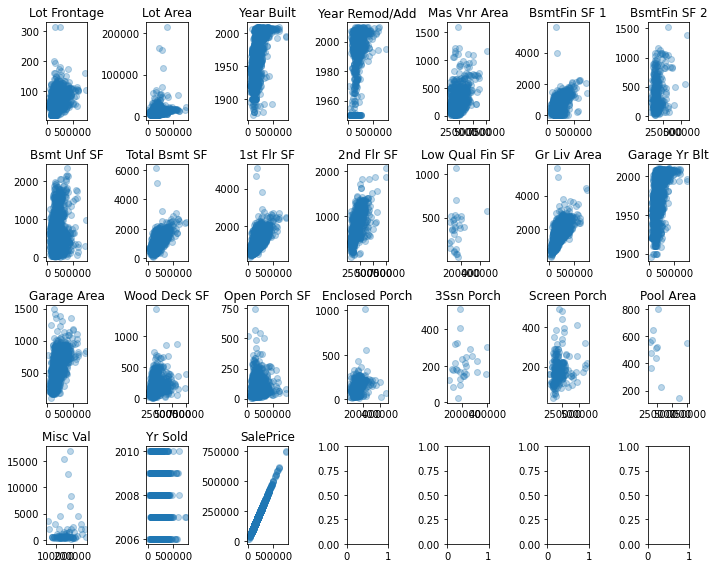

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(10, 8))

for column, ax in zip(df_num.columns, axes.ravel()):
    ax.scatter(df_num.SalePrice, df[column],alpha=0.3)
    ax.set_title(column)

plt.tight_layout() 
plt.show()

At first glance there seems to be some outliers for most of the variables. Let's inspect 'Gr Liv Area' as proposed in the documentation:

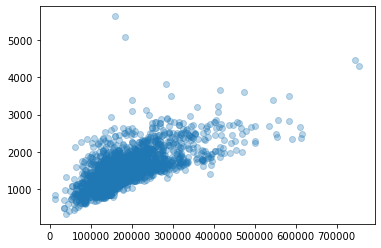

In [32]:
plt.scatter(df.SalePrice, df['Gr Liv Area'],alpha=0.3)

As stated in the documentation I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before continuing with the analysis. We can already spot outliers on the fly while investigating on the variables (e.g. 'Lot Area' has a max value which is 20 times higher than the 75% quantile):

In [33]:
df.describe()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,1127.000000,972.000000,1656.000000,294.000000,2219.000000,...,1158.000000,1350.000000,375.000000,29.000000,218.000000,12.000000,88.000000,2430.000000,2430.000000,2430.000000
mean,68.953498,10243.557613,6.088889,5.569959,1971.167490,1986.162378,252.889918,651.172101,421.965986,609.144660,...,197.081174,84.765185,144.469333,207.103448,184.247706,486.250000,1551.329545,6.209465,2007.783539,180199.692593
std,22.083366,8353.925254,1.414621,1.116442,30.207931,22.545815,197.954434,414.707338,297.530907,423.672958,...,118.763772,70.121395,87.062726,99.030423,71.394620,176.928915,2875.912676,2.721942,1.311843,79607.467171
min,21.000000,1470.000000,1.000000,1.000000,1875.000000,1950.000000,1.000000,2.000000,6.000000,14.000000,...,4.000000,4.000000,16.000000,23.000000,40.000000,144.000000,80.000000,1.000000,2006.000000,12789.000000
25%,58.000000,7482.000000,5.000000,5.000000,1954.000000,1956.500000,120.000000,357.500000,173.250000,279.000000,...,123.000000,39.000000,89.000000,153.000000,144.000000,425.000000,450.000000,4.000000,2007.000000,129000.000000
50%,70.000000,9500.000000,6.000000,5.000000,1973.000000,1996.000000,200.000000,608.000000,373.500000,520.000000,...,169.500000,63.000000,135.000000,180.000000,174.500000,515.500000,600.000000,6.000000,2008.000000,160000.000000
75%,80.000000,11604.500000,7.000000,6.000000,2000.000000,2004.000000,320.500000,877.000000,607.500000,835.500000,...,239.000000,109.500000,192.000000,245.000000,216.000000,564.750000,1225.000000,8.000000,2009.000000,213099.750000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,...,1424.000000,742.000000,1012.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


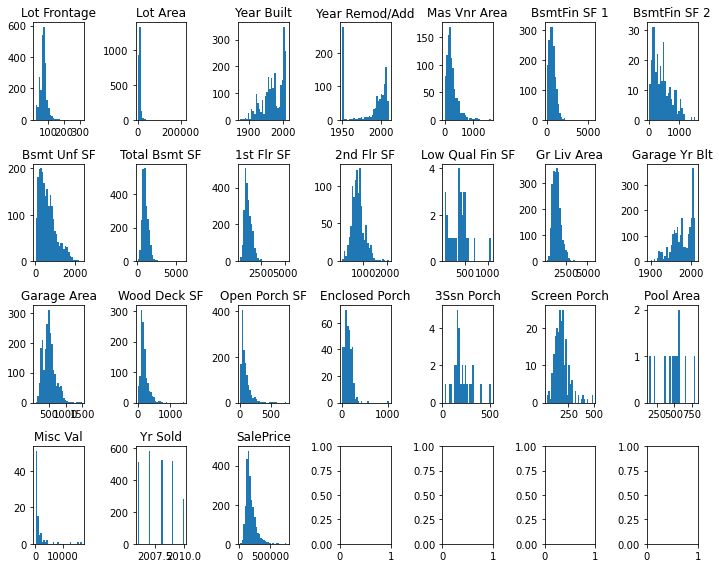

In [34]:
# A quick look at the distribution of the variables
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(10, 8))

for c, ax in zip(df_num.dropna(), axes.ravel()):
    ax.hist(df[c], bins=30)
    ax.set_title(c)

plt.tight_layout() 
plt.show()

Remove outliers based on IQR since the distributions of the numeric features is skewed (see histograms):

In [35]:
# use df.loc[:,df_num.columns]
Q1 = np.percentile(df.loc[:,df_num.columns], 25, axis=0)
Q3 = np.percentile(df.loc[:,df_num.columns], 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [36]:
boxplot_filter = (df.loc[:,df_num.columns] < lower_bound) | (df.loc[:,df_num.columns] > upper_bound)
print("Number of outliers detected per feature using a boxplot:")
print(boxplot_filter.sum(axis=0))
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())

Number of outliers detected per feature using a boxplot:
Lot Frontage       153
Lot Area           108
Year Built           6
Year Remod/Add       0
Mas Vnr Area         0
BsmtFin SF 1         0
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
1st Flr SF          36
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area         54
Garage Yr Blt        0
Garage Area          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Yr Sold              0
SalePrice          110
dtype: int64
Total number of outliers detected: 467


In case all outliers are values on different rows the outliers selection would remove about 1/5 of all data points. This is why we should replace the respective values with NaN instead of removing the entire row:

In [37]:
for column in boxplot_filter.drop('SalePrice', axis=1).columns:
    boxplot_filter_any  = boxplot_filter[boxplot_filter[column] == True].loc[:,[column]].index
    df.loc[boxplot_filter_any, column] = np.nan

Outliers removed? Apparently Yes because 'Lot Area' has a max value which is much lower than 20 times the 75% quantile

In [38]:
df.describe()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2277.000000,2322.000000,2430.000000,2430.000000,2424.000000,1127.000000,972.000000,1656.000000,294.000000,2219.000000,...,1158.000000,1350.000000,375.000000,29.000000,218.000000,12.000000,88.000000,2430.000000,2430.000000,2430.000000
mean,68.521739,9220.711025,6.088889,5.569959,1971.395627,1986.162378,252.889918,651.172101,421.965986,609.144660,...,197.081174,84.765185,144.469333,207.103448,184.247706,486.250000,1551.329545,6.209465,2007.783539,180199.692593
std,15.988039,3249.449364,1.414621,1.116442,29.894529,22.545815,197.954434,414.707338,297.530907,423.672958,...,118.763772,70.121395,87.062726,99.030423,71.394620,176.928915,2875.912676,2.721942,1.311843,79607.467171
min,25.000000,1470.000000,1.000000,1.000000,1885.000000,1950.000000,1.000000,2.000000,6.000000,14.000000,...,4.000000,4.000000,16.000000,23.000000,40.000000,144.000000,80.000000,1.000000,2006.000000,12789.000000
25%,60.000000,7316.500000,5.000000,5.000000,1954.000000,1956.500000,120.000000,357.500000,173.250000,279.000000,...,123.000000,39.000000,89.000000,153.000000,144.000000,425.000000,450.000000,4.000000,2007.000000,129000.000000
50%,70.000000,9301.500000,6.000000,5.000000,1973.000000,1996.000000,200.000000,608.000000,373.500000,520.000000,...,169.500000,63.000000,135.000000,180.000000,174.500000,515.500000,600.000000,6.000000,2008.000000,160000.000000
75%,80.000000,11191.500000,7.000000,6.000000,2000.250000,2004.000000,320.500000,877.000000,607.500000,835.500000,...,239.000000,109.500000,192.000000,245.000000,216.000000,564.750000,1225.000000,8.000000,2009.000000,213099.750000
max,113.000000,17778.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,...,1424.000000,742.000000,1012.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


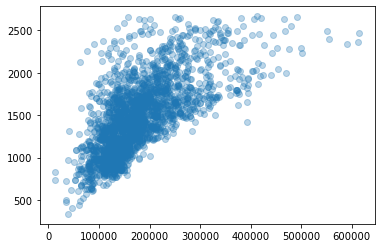

In [39]:
plt.scatter(df.SalePrice, df['Gr Liv Area'],alpha=0.3)

The 5 unusual observations have been removed by setting to NaN. Let's check for ther other variables:

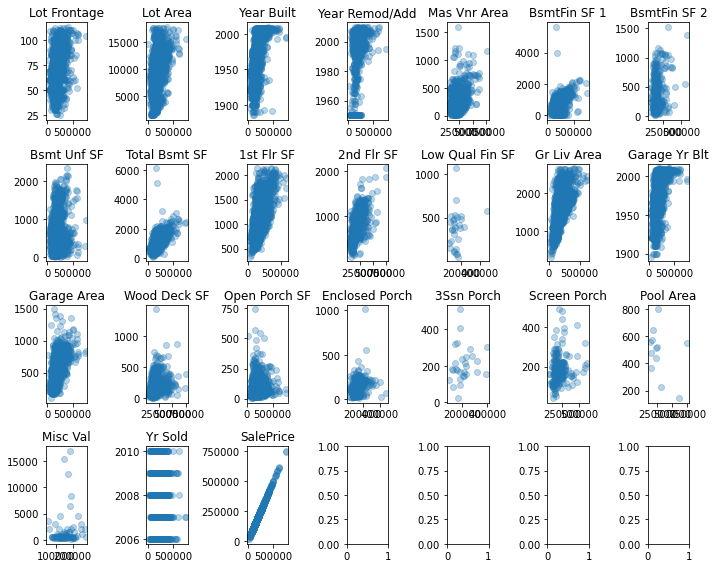

In [40]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(10, 8))

for column, ax in zip(df_num.columns, axes.ravel()):
    ax.scatter(df_num.SalePrice, df[column],alpha=0.3)
    ax.set_title(column)

plt.tight_layout() 
plt.show()

By visual inspection we can still spot a few outliers. Let's set them to NaN as well:

In [41]:
df.loc[df[df['BsmtFin SF 1']>3000].loc[:,['BsmtFin SF 1']].index, 'BsmtFin SF 1']= np.nan
df.loc[df[df['Total Bsmt SF']>4000].loc[:,['Total Bsmt SF']].index, 'Total Bsmt SF']= np.nan
df.loc[df[df['Low Qual Fin SF']>1000].loc[:,['Low Qual Fin SF']].index, 'Low Qual Fin SF']= np.nan
df.loc[df[df['Wood Deck SF']>1000].loc[:,['Wood Deck SF']].index, 'Wood Deck SF']= np.nan
df.loc[df[df['Enclosed Porch']>900].loc[:,['Enclosed Porch']].index, 'Enclosed Porch']= np.nan
df.loc[df[df['Misc Val']>10000].loc[:,['Misc Val']].index, 'Misc Val']= np.nan

After the continuous variables we can inspect the non-continuous variables for potential outliers:

In [42]:
columns = df_discrete.columns
for column in columns:
    print(column, sorted(set(df[column].unique())))

Bsmt Full Bath [0.0, 1.0, 2.0, 3.0, nan]
Bsmt Half Bath [0.0, 1.0, 2.0, nan]
Full Bath [0, 1, 2, 3, 4]
Half Bath [0, 1, 2]
Bedroom AbvGr [0, 1, 2, 3, 4, 5, 6, 8]
Kitchen AbvGr [0, 1, 2, 3]
TotRms AbvGrd [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Fireplaces [0, 1, 2, 3, 4]
Garage Cars [0.0, 1.0, 2.0, 3.0, 4.0, nan]
Mo Sold [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Overall Qual [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Overall Cond [1, 2, 3, 4, 5, 6, 7, 8, 9]


No outlier or unusual value detected (e.g. TotRms AbvGrd of 0 would not make sense)

In [43]:
columns = df_ordinals.columns
for column in columns:
    print(column, df[column].unique())

Alley [nan 'Grvl' 'Pave']
Bsmt Qual ['Gd' 'TA' 'Ex' nan 'Fa' 'Po']
Bsmt Cond ['TA' 'Gd' 'Fa' nan 'Ex' 'Po']
Bsmt Exposure ['No' 'Av' 'Mn' 'Gd' nan]
BsmtFin Type 1 ['GLQ' 'Unf' 'Rec' 'LwQ' 'BLQ' 'ALQ' nan]
BsmtFin Type 2 ['Unf' 'LwQ' 'BLQ' nan 'Rec' 'ALQ' 'GLQ']
Fireplace Qu ['TA' 'Gd' nan 'Fa' 'Po' 'Ex']
Garage Type ['BuiltIn' 'Attchd' 'Detchd' nan '2Types' 'Basment' 'CarPort']
Garage Finish ['Fin' 'Unf' 'RFn' nan]
Garage Qual ['TA' 'Fa' nan 'Gd' 'Ex' 'Po']
Garage Cond ['TA' nan 'Fa' 'Gd' 'Ex' 'Po']
Pool QC [nan 'Fa' 'Ex' 'TA' 'Gd']
Fence [nan 'MnPrv' 'MnWw' 'GdPrv' 'GdWo']
Misc Feature [nan 'Shed' 'Othr' 'Elev' 'Gar2' 'TenC']


No outlier or unusual value detected

In [44]:
columns = df.select_dtypes('object').columns
for column in columns:
    print(column, df[column].unique())

Order [484 2586 2289 ... 1654 2608 2733]
PID [528275070 535305120 923228250 ... 527353080 535402070 905402110]
MS SubClass [60 20 160 190 50 70 120 30 90 85 45 80 180 75 40 150]
MS Zoning ['RL' 'RM' 'FV' 'I (all)' 'C (all)' 'RH' 'A (agr)']
Street ['Pave' 'Grvl']
Alley [nan 'Grvl' 'Pave']
Lot Shape ['IR1' 'Reg' 'IR2' 'IR3']
Land Contour ['Lvl' 'Bnk' 'HLS' 'Low']
Utilities ['AllPub' 'NoSewr' 'NoSeWa']
Lot Config ['Inside' 'Corner' 'CulDSac' 'FR2' 'FR3']
Land Slope ['Gtl' 'Mod' 'Sev']
Neighborhood ['Gilbert' 'NAmes' 'MeadowV' 'OldTown' 'SawyerW' 'Somerst' 'Timber'
 'Edwards' 'NWAmes' 'Mitchel' 'CollgCr' 'NridgHt' 'IDOTRR' 'NoRidge'
 'GrnHill' 'Crawfor' 'StoneBr' 'BrDale' 'BrkSide' 'Landmrk' 'SWISU'
 'Sawyer' 'ClearCr' 'Greens' 'Veenker' 'Blueste' 'NPkVill' 'Blmngtn']
Condition 1 ['Norm' 'Feedr' 'PosN' 'RRAe' 'Artery' 'PosA' 'RRAn' 'RRNn' 'RRNe']
Condition 2 [nan 'Norm' 'Feedr' 'Artery' 'RRNn' 'RRAe' 'PosA' 'RRAn']
Bldg Type ['1Fam' 'Twnhs' '2fmCon' 'TwnhsE' 'Duplex']
House Style ['2Story'

No outlier or unusual value detected

## Feature encoding

Your analysis should include the necessary feature encoding steps. The documentation.txt file labels each variable with its type. For categorical ones, it uses the ordinal, nominal and discrete classification.

- Ordinal variables - you can order the categories
- Nominal variables - no possible ordering
- Discrete variables - categories are integer values

The encoding depends on the type of variable and its meaning. For instance, the kitchen quality variable is on a scale from excellent to poor. Hence, it's an ordinal variable, and you can choose to apply one-hot encoding or define a numerical scale ex. excellent corresponds to 5 and poor to 1. In any case, justify your choices!

One-hot encoding is a common transformation for (categorial) features that have **non-linear** relationships with the target to add more flexibility to linear models. For ordinal variables we should apply hot-encoding instead of defining a numerical scale. The reason is that a numerical scale is not really useful in this format (we compared the two R^2 coefficients in the example with bike-small.csv - both are very close whereas encoding the variable has resulted in a much higher score). In addition we can also include 'Yr Sold' in the hot-encoding.

**One-Hot-Encoding (OHE) variables**: 
> 'MS SubClass', 'MS Zoning', 'Street', 'Alley',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Mo Sold', 'Yr Sold' 

In [45]:
df_ohe = df.loc[:,['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type', 'Sale Condition', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Mo Sold', 'Yr Sold']]

In [46]:
encoded_df = pd.get_dummies(df,columns=df_ohe.columns, dummy_na=False, drop_first=True)
encoded_df

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Mo Sold_7,Mo Sold_8,Mo Sold_9,Mo Sold_10,Mo Sold_11,Mo Sold_12,Yr Sold_2007.0,Yr Sold_2008.0,Yr Sold_2009.0,Yr Sold_2010.0
0,484,528275070,70.0,8795.0,7,5,2000.0,NaN,NaN,300.0,...,0,0,0,0,0,0,0,0,1,0
1,2586,535305120,75.0,10170.0,6,6,1951.0,NaN,522.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2289,923228250,NaN,2001.0,4,5,1970.0,NaN,80.0,NaN,...,0,0,0,0,0,0,1,0,0,0
3,142,535152150,70.0,10552.0,5,5,1959.0,NaN,NaN,1018.0,...,0,0,0,0,0,0,0,0,0,1
4,2042,903475060,60.0,10120.0,7,4,1910.0,1950.0,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,764,904301070,60.0,10800.0,5,5,1987.0,1988.0,NaN,1200.0,...,0,0,0,0,0,0,0,0,1,0
2426,836,907126010,82.0,12464.0,5,5,1996.0,NaN,NaN,732.0,...,0,0,0,0,1,0,0,0,1,0
2427,1654,527353080,80.0,11584.0,7,6,1979.0,NaN,96.0,315.0,...,0,0,0,0,1,0,1,0,0,0
2428,2608,535402070,85.0,13400.0,5,5,1966.0,NaN,1047.0,516.0,...,0,0,0,0,0,0,0,0,0,0


## Feature Engineering

- '1st Flr SF', '2nd Flr SF': add another column Total Floors (0: if '2nd Flr SF'>0, otherwise: 1) 
- 'Garage Area' and 'Garage Cars': drop 'Garage Cars' because it's measuring the same area but less precise than 'Garage Area' 

Those variables don't add "modeling power" to the model if you keep the original features in the data and can lead to ill-conditioning and numerical issues. On the other hand, if you create such variables and **remove the original features**, it can be seen as a way to compress the information on fewer dimensions which can be useful for the **simple and intermediate** models where the number of variables is limited.

In [47]:
def transform(x):
    if x > 0:
        return 1
    elif x == np.nan:
        return 0
    return x

In [48]:
df['2nd Flr SF'] = df['2nd Flr SF'].apply(transform)

In [49]:
df = df.drop(['Garage Cars'], axis=1)

In [50]:
df_ohe = df_ohe.drop(['Garage Cars'], axis=1)

Many of the continuous variables have a skewed distribution according to the histograms:

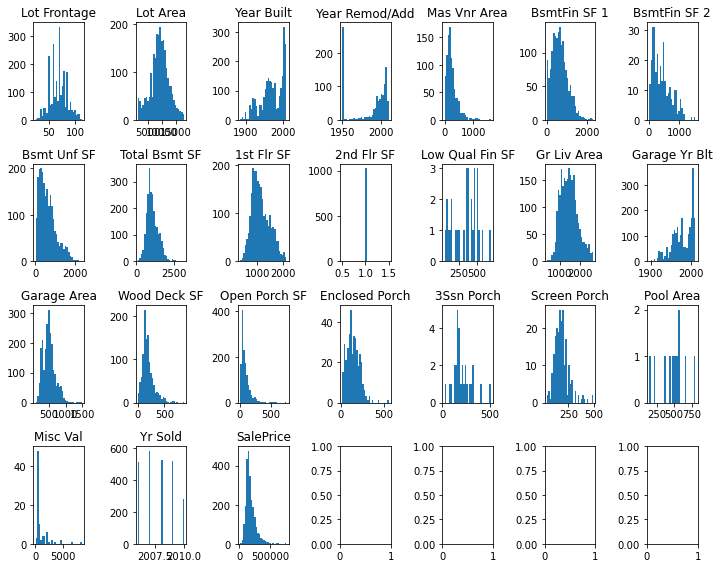

In [51]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(10, 8))

for c, ax in zip(df_num.dropna(), axes.ravel()):
    ax.hist(df[c], bins=30)
    ax.set_title(c)

plt.tight_layout() 
plt.show()

This is why we have to apply a log-transform to the following features:
> 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF','1st Flr SF','Garage Area', 'Wood Deck SF','Open Porch SF', 'Enclosed Porch','Screen Porch', 'Misc Val'

In [52]:
continuous_log = df.loc[:,df[['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF','1st Flr SF','Garage Area', 'Wood Deck SF','Open Porch SF', 'Enclosed Porch','Screen Porch', 'Misc Val']].columns].columns

In [53]:
df[continuous_log] = np.log1p(df[continuous_log])

With the log-transform the distributions of the respective features are more normalized:

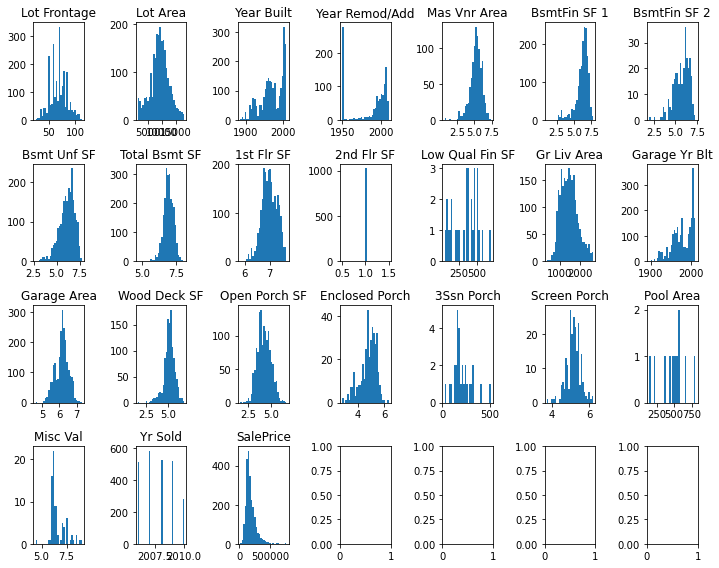

In [54]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(10, 8))

for c, ax in zip(df_num.dropna(), axes.ravel()):
    ax.hist(df[c], bins=30)
    ax.set_title(c)

plt.tight_layout() 
plt.show()

## Model fitting

Your analysis should include an appropriate baseline and evaluate three different models ranging in complexity

- A **simple** model with two variables (three with the target variable)
- An **intermediate** model (between 10 and 20 variables)
- A **complex** model with all variables

The number of variables is only given as an indication, it's not a strict range. Also, it corresponds to the variables count **before** one-hot encoding. For the simple and intermediate models, you can choose the variables. You are free to choose your preferred approach for this variable selection step, but you should include a short comment to explain your choice.

Your analysis should include regularization for at least the complex model, tune its strength with **grid search** and plot the **validation curves**.

## Compute predictions

Make predictions for the 500 new houses from house-prices-test.csv using each model and save them in a .csv file.

- Predictions from your simple model - predictions-simple-model.csv
- Predictions from your intermediate model - predictions-intermediate-model.csv
- Predictions from your complex model - predictions-complex-model.csv

Your .csv files must contain 500 rows and 2 columns: the house PID and the predicted price as SalePrice.
You can find a sample submission file in predictions-example.csv. Be careful to respect the column names.

In [55]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

Define preprocessing function (one-hot-encoding, fillna, add polynomial features):

When we square positive numbers the same distance between larger x-values is stretched more than for smaller x-values. But we don't know whether that is apriori a suitable choice. Maybe we want the opposite effect. The square root function does just that: the same distance between larger x-values is stretched less than for smaller x-values. By using both powers we can cover both behaviors. Add their polynomial features of degree 2, 3 and 0.5 (square root).

In [56]:
df_num.columns.intersection(df_ohe.columns)

Index(['Yr Sold'], dtype='object')

In [57]:
# Preprocessing function

def preprocess(df):
    # Work on a copy
    df = df.copy()

    # Fill missing values
    for c in df.columns:
        df[c] = df[c].fillna(0)
        
    # Add polynomial features
    for c in df.columns.intersection(df_num.drop(['Year Built', 'Year Remod/Add','Yr Sold', 'SalePrice'], axis=1).columns):
        for d in [0.5, 2, 3]:
            name = '{}**{}'.format(c, d)
            df[name] = df[c]**d
            
    # One-hot encoding
    df = pd.get_dummies(df,columns=df.columns.intersection(df_ohe.drop(['Yr Sold'], axis=1).columns), dummy_na=False, drop_first=True)

    return df

---

A **simple** model 

Since I have to select a subset of the overall features, my decision should be based on the EDA to select the features that are more decisive (i.e. that affects the price the most) and can be ranked in order of importance after the EDA. The limit, in this case, is relative (I willpick the top features based on their relative correlation scores).

Correlation of SalesPrice with all other features:

In [58]:
df.corr().iloc[-1,:].sort_values()

Pool Area         -0.317338
Kitchen AbvGr     -0.119954
Overall Cond      -0.102353
Bsmt Half Bath    -0.026990
Yr Sold           -0.026386
Mo Sold            0.035734
Bsmt Unf SF        0.080655
3Ssn Porch         0.123987
Open Porch SF      0.127996
Bedroom AbvGr      0.133007
Misc Val           0.146286
BsmtFin SF 2       0.158883
Screen Porch       0.206496
Wood Deck SF       0.207452
Enclosed Porch     0.208544
Low Qual Fin SF    0.273437
Bsmt Full Bath     0.278545
Half Bath          0.279828
BsmtFin SF 1       0.309986
Lot Frontage       0.334977
Mas Vnr Area       0.382530
Lot Area           0.415868
Year Remod/Add     0.478920
TotRms AbvGrd      0.483882
Fireplaces         0.492056
Garage Yr Blt      0.535601
Full Bath          0.536616
Year Built         0.564739
1st Flr SF         0.589395
Total Bsmt SF      0.599625
Garage Area        0.600780
Gr Liv Area        0.682238
Overall Qual       0.799022
SalePrice          1.000000
2nd Flr SF              NaN
Name: SalePrice, dty

In [59]:
df[['Year Built', 'Gr Liv Area', 'Overall Qual']].isnull().sum()

Year Built       6
Gr Liv Area     54
Overall Qual     0
dtype: int64

Year Built, Gr Liv Area and Overall Qual look like strong variables to predict SalePrice with a low proportion of null values (i.e. carrying a lot of information about the target value). 

In [60]:
df_simple = pd.DataFrame(columns=['Year Built', 'Gr Liv Area', 'Overall Qual'])

In [61]:
df_simple.columns.intersection(df_ohe.columns)

Index([], dtype='object')

Train **simple** model and calculate test data target values:

In [62]:
df_test = pd.read_csv('house-prices-test.csv')

In [63]:
df_simple = df[['Year Built', 'Gr Liv Area', 'Overall Qual']]

In [64]:
preprocessed_df_simple = preprocess(df_simple)
preprocessed_df_simple.head()

,Year Built,Gr Liv Area,Overall Qual,Gr Liv Area**0.5,Gr Liv Area**2,Gr Liv Area**3
0,2000.0,2256.0,7,47.497368,5089536.0,1.148199e+10
1,1951.0,1575.0,6,39.686270,2480625.0,3.906984e+09
2,1970.0,1092.0,4,33.045423,1192464.0,1.302171e+09
3,1959.0,1700.0,5,41.231056,2890000.0,4.913000e+09
4,1910.0,1889.0,7,43.462628,3568321.0,6.740558e+09


In [65]:
X_tr_cols_simple = list(preprocessed_df_simple)

In [66]:
X = preprocessed_df_simple.values

In [67]:
y = df.SalePrice.values

In [68]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)

In [69]:
scaler_simple = StandardScaler()
X_tr_rescaled = scaler_simple.fit_transform(X_tr)
X_te_rescaled = scaler_simple.transform(X_te)

In [70]:
ridge_simple = Ridge()
ridge_simple.fit(X_tr_rescaled, y_tr)

Ridge()

In [71]:
print('train_MAE_intermediate:', MAE(y_tr, ridge_simple.predict(X_tr_rescaled)))
print('test_MAE_intermediate:', MAE(y_te, ridge_simple.predict(X_te_rescaled)))

train_MAE_intermediate: 28553.8275371884
test_MAE_intermediate: 27421.000453999462


In [72]:
test_MAE_simple = MAE(y_te, ridge_simple.predict(X_te_rescaled))

Calculate test data target value:

In [73]:
df_simple_test = df_test[df_simple.columns]

In [74]:
preprocessed_df_simple = preprocess(df_simple_test)
preprocessed_df_simple.head()

,Year Built,Gr Liv Area,Overall Qual,Gr Liv Area**0.5,Gr Liv Area**2,Gr Liv Area**3
0,1932,1991,6,44.620623,3964081,7892485271
1,1994,990,5,31.464265,980100,970299000
2,2006,1970,8,44.384682,3880900,7645373000
3,1960,1134,5,33.674916,1285956,1458274104
4,1900,1178,4,34.322005,1387684,1634691752


In [75]:
X_tmp=preprocessed_df_simple.reindex(X_tr_cols_simple, axis="columns")

In [76]:
X_tmp=X_tmp.fillna(0)

In [77]:
X = X_tmp.values

In [78]:
X_rescaled = scaler_simple.transform(X)

In [79]:
ridge_simple.predict(X_rescaled)[0:10]

array([201790.54946407, 122123.24587433, 274674.46636981, 121594.60774871,
        83755.4879296 , 177798.60962849,  47951.66998922, 155750.40435791,
       132804.45607512,  87697.90600768])

In [80]:
d = {'PID': df_test.PID, 'SalePrice': ridge_simple.predict(X_rescaled).astype('int64')}

In [81]:
y_test_simple = pd.DataFrame(data=d)

In [82]:
y_test_simple.head()

,PID,SalePrice
0,909279080,201790
1,907126050,122123
2,528144030,274674
3,535452060,121594
4,911202100,83755


In [83]:
y_test_simple.to_csv('predictions-simple-model.csv', index=False)

---

Train **intermediate** model and calculate test data target values:

In [84]:
df_intermediate = df[['Year Built', 'Gr Liv Area', 'Overall Qual','Year Remod/Add','1st Flr SF', 'Garage Yr Blt', 'Garage Area', 'Full Bath', 'Total Bsmt SF','MS Zoning', 'Utilities', 'Kitchen AbvGr', 'Functional', 'Sale Type', 'Sale Condition']]

In [85]:
preprocessed_df_intermediate = preprocess(df_intermediate)
preprocessed_df_intermediate.head()

,Year Built,Gr Liv Area,Overall Qual,Year Remod/Add,1st Flr SF,Garage Yr Blt,Garage Area,Total Bsmt SF,Gr Liv Area**0.5,Gr Liv Area**2,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,2000.0,2256.0,7,0.0,6.888572,2000.0,6.318968,6.859615,47.497368,5089536.0,...,0,0,0,0,1,0,0,0,1,0
1,1951.0,1575.0,6,0.0,7.362645,1951.0,5.993961,5.379897,39.686270,2480625.0,...,0,0,0,0,1,0,0,0,1,0
2,1970.0,1092.0,4,0.0,6.304449,1970.0,5.659482,6.304449,33.045423,1192464.0,...,0,0,0,0,1,0,0,0,1,0
3,1959.0,1700.0,5,0.0,7.438972,1959.0,6.104793,7.243513,41.231056,2890000.0,...,0,0,0,0,1,0,0,0,1,0
4,1910.0,1889.0,7,1950.0,6.872128,1960.0,5.733341,6.830874,43.462628,3568321.0,...,0,0,0,0,1,0,0,0,1,0


In [86]:
X_tr_cols_intermediate = list(preprocessed_df_intermediate)

In [87]:
X = preprocessed_df_intermediate.values

In [88]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)

In [89]:
scaler_intermediate = StandardScaler()
X_tr_rescaled = scaler_intermediate.fit_transform(X_tr)
X_te_rescaled = scaler_intermediate.transform(X_te)

In [90]:
ridge_intermediate = Ridge()
ridge_intermediate.fit(X_tr_rescaled, y_tr)

Ridge()

In [91]:
print('train_MAE_intermediate:', MAE(y_tr, ridge_intermediate.predict(X_tr_rescaled)))
print('test_MAE_intermediate:', MAE(y_te, ridge_intermediate.predict(X_te_rescaled)))

train_MAE_intermediate: 21308.574090753093
test_MAE_intermediate: 21640.171321747894


In [92]:
test_MAE_intermediate = MAE(y_te, ridge_intermediate.predict(X_te_rescaled))

Calculate test data target value:

In [93]:
df_test_intermediate = df_test[df_intermediate.columns]

In [94]:
preprocessed_df_intermediate  = preprocess(df_test_intermediate)
preprocessed_df_intermediate.head()

,Year Built,Gr Liv Area,Overall Qual,Year Remod/Add,1st Flr SF,Garage Yr Blt,Garage Area,Total Bsmt SF,Gr Liv Area**0.5,Gr Liv Area**2,...,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1932,1991,6,1950,1096,1977.0,432.0,854.0,44.620623,3964081,...,0,0,0,0,1,0,0,0,1,0
1,1994,990,5,1994,990,1995.0,440.0,990.0,31.464265,980100,...,0,0,0,0,1,0,0,0,1,0
2,2006,1970,8,2006,1120,2006.0,753.0,1085.0,44.384682,3880900,...,0,0,1,0,0,0,0,0,0,1
3,1960,1134,5,2002,1134,1960.0,254.0,1010.0,33.674916,1285956,...,0,0,0,0,1,0,0,1,0,0
4,1900,1178,4,1950,859,1964.0,384.0,859.0,34.322005,1387684,...,0,0,0,0,1,0,0,0,0,0


In [95]:
X_tmp = preprocessed_df_intermediate.reindex(X_tr_cols_intermediate, axis="columns")

In [96]:
X_tmp = X_tmp.fillna(0)

In [97]:
X = X_tmp.values

In [98]:
X_rescaled = scaler_intermediate.transform(X)

In [99]:
ridge_intermediate.predict(X_rescaled)[0:10]

array([1.12844445e+12, 1.25766473e+12, 1.89204995e+12, 1.48303024e+12,
       8.21443258e+11, 6.15541535e+11, 2.35141956e+11, 1.28516642e+12,
       4.01720638e+12, 8.46742109e+11])

In [100]:
d = {'PID': df_test.PID, 'SalePrice': ridge_intermediate.predict(X_rescaled).astype('int64')}

In [101]:
y_test_intermediate = pd.DataFrame(data=d)

In [102]:
y_test_intermediate.head()

,PID,SalePrice
0,909279080,1128444453445
1,907126050,1257664727589
2,528144030,1892049954664
3,535452060,1483030240030
4,911202100,821443258461


In [103]:
y_test_intermediate.to_csv('predictions-intermediate-model.csv', index=False)

-----

Train **complex** model and calculate test data target values:

In [104]:
preprocessed_df_complex = preprocess(df.drop('SalePrice', axis=1))
preprocessed_df_complex.head()

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,484,528275070,70.0,8795.0,7,5,2000.0,0.0,0.000000,5.707110,...,0,0,0,0,1,0,0,0,1,0
1,2586,535305120,75.0,10170.0,6,6,1951.0,0.0,6.259581,0.000000,...,0,0,0,0,1,0,0,0,1,0
2,2289,923228250,0.0,2001.0,4,5,1970.0,0.0,4.394449,0.000000,...,0,0,0,0,1,0,0,0,1,0
3,142,535152150,70.0,10552.0,5,5,1959.0,0.0,0.000000,6.926577,...,0,0,0,0,1,0,0,0,1,0
4,2042,903475060,60.0,10120.0,7,4,1910.0,1950.0,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0


In [105]:
X_tr_cols_complex = list(preprocessed_df_complex)

In [106]:
X = preprocessed_df_complex.values

In [107]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)

In [108]:
scaler_complex = StandardScaler()
X_tr_rescaled = scaler_complex.fit_transform(X_tr)
X_te_rescaled = scaler_complex.transform(X_te)

In [109]:
ridge_complex = Ridge()
ridge_complex.fit(X_tr_rescaled, y_tr)
print('train_mae:', MAE(y_tr, ridge_complex.predict(X_tr_rescaled)))
print('test_mae:', MAE(y_te, ridge_complex.predict(X_te_rescaled)))

train_mae: 12504.334642660242
test_mae: 19036.23499064132


As you can see the train_mae is the lowest of all three models. However we will iterate over a list of alpha values and pick the one with the best test score. We want to find hyperparameters that minimize the generalization error.

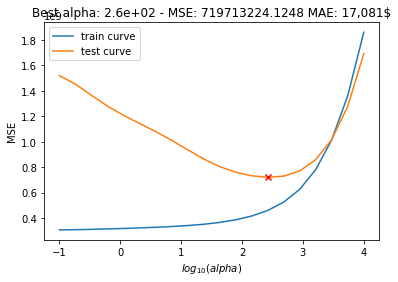

In [110]:
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-1, 4, num=20):
    # Create and fit ridge regression
    ridge_complex = Ridge(alpha=alpha)
    ridge_complex.fit(X_tr_rescaled, y_tr)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'model': ridge_complex,
        'alpha': alpha,
        'train_mse': MSE(y_tr, ridge_complex.predict(X_tr_rescaled)),
        'train_mae': MAE(y_tr, ridge_complex.predict(X_tr_rescaled)),
        'test_mse': MSE(y_te, ridge_complex.predict(X_te_rescaled)),
        'test_mae': MAE(y_te, ridge_complex.predict(X_te_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

# Plot the validation curves
plt.plot(np.log10(gs_results['alpha']), gs_results['train_mse'], label='train curve')
plt.plot(np.log10(gs_results['alpha']), gs_results['test_mse'], label='test curve')

# Mark best alpha value
best_result = gs_results.loc[gs_results.test_mse.idxmin()]
plt.scatter(np.log10(best_result.alpha), best_result.test_mse, marker='x', c='red', zorder=10)
plt.title('Best alpha: {:.1e} - MSE: {:.4f} MAE: {:,.0f}$'.format(
    best_result.alpha, best_result.test_mse, best_result.test_mae))

plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

The test MAE score is now lower compared to the regression without grid search. 

In [111]:
ridge_complex = Ridge(alpha=2.6e+02)
ridge_complex.fit(X_tr_rescaled, y_tr)
print('train_MAE_complex:', MAE(y_tr, ridge_complex.predict(X_tr_rescaled)))
print('test_MAE_complex:', MAE(y_te, ridge_complex.predict(X_te_rescaled)))

train_MAE_complex: 14862.073041816875
test_MAE_complex: 17082.068183335043


In [112]:
test_MAE_complex = MAE(y_te, ridge_complex.predict(X_te_rescaled))

Calculate test data target value:

In [113]:
df_test_complex = df_test[df.drop('SalePrice', axis=1).columns]

In [114]:
preprocessed_df_complex  = preprocess(df_test_intermediate)
preprocessed_df_complex.head()

,Year Built,Gr Liv Area,Overall Qual,Year Remod/Add,1st Flr SF,Garage Yr Blt,Garage Area,Total Bsmt SF,Gr Liv Area**0.5,Gr Liv Area**2,...,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1932,1991,6,1950,1096,1977.0,432.0,854.0,44.620623,3964081,...,0,0,0,0,1,0,0,0,1,0
1,1994,990,5,1994,990,1995.0,440.0,990.0,31.464265,980100,...,0,0,0,0,1,0,0,0,1,0
2,2006,1970,8,2006,1120,2006.0,753.0,1085.0,44.384682,3880900,...,0,0,1,0,0,0,0,0,0,1
3,1960,1134,5,2002,1134,1960.0,254.0,1010.0,33.674916,1285956,...,0,0,0,0,1,0,0,1,0,0
4,1900,1178,4,1950,859,1964.0,384.0,859.0,34.322005,1387684,...,0,0,0,0,1,0,0,0,0,0


In [115]:
X_tmp = preprocessed_df_complex.reindex(X_tr_cols_complex, axis="columns")

In [116]:
X_tmp = X_tmp.fillna(0)

In [117]:
X = X_tmp.values

In [118]:
X_rescaled = scaler_complex.transform(X)

In [119]:
ridge_complex.predict(X_rescaled)[0:10]

array([1.38524107e+11, 1.43242753e+11, 2.18008539e+11, 1.74688393e+11,
       9.36869386e+10, 7.05964914e+10, 3.38504591e+10, 1.46693778e+11,
       4.55865797e+11, 1.20321351e+11])

In [120]:
d = {'PID': df_test.PID, 'SalePrice': ridge_complex.predict(X_rescaled).astype('int64')}

In [121]:
y_test_complex = pd.DataFrame(data=d)

In [122]:
y_test_complex.head()

,PID,SalePrice
0,909279080,138524107448
1,907126050,143242752866
2,528144030,218008538955
3,535452060,174688393183
4,911202100,93686938648


In [123]:
y_test_complex.to_csv('predictions-complex-model.csv', index=False)

---

MAE **baseline** calculation:

The sklearn MAE function does not support a constant value of the median. 

In [124]:
# mae_baseline = MAE(10**y_te), np.median(10**X_tr)) --> returns an error

Therefore, you need to pass an array:

In [125]:
MAE(y_te, np.full(y_te.shape, np.median(y_te)))

54622.248559670785

In [126]:
MAE_baseline = np.mean(np.abs(y_te - np.median(y_tr)))
MAE_baseline

54741.624691358025

---

My models have the folowing MAE (in thousand dollars)

- baseline: 54'741
- simple model: 27'421
- intermediate model: 19'036
- complex model: 17'082

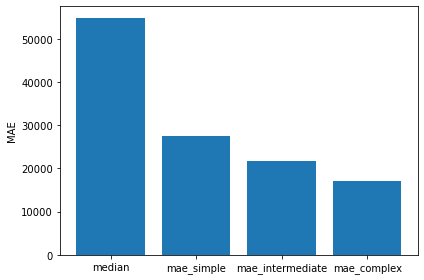

In [127]:
# Final comparison
MAE_values = [MAE_baseline, test_MAE_simple, test_MAE_intermediate, test_MAE_complex]
titles = ['median', 'mae_simple', 'mae_intermediate', 'mae_complex']

xcor = np.arange(len(MAE_values))
plt.bar(xcor, MAE_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.tight_layout()
plt.show()